In [ ]:
!pip install datasets transformers evaluate langchain faiss-cpu langchain-google-genai langchain-community

In [ ]:
!pip install rouge_score

In [ ]:
import time
import numpy as np
import pandas as pd
import evaluate
from transformers import pipeline
from datasets import load_dataset
from datasets import concatenate_datasets
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA, LLMChain
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from google.api_core.exceptions import ResourceExhausted



In [ ]:
full_val = load_dataset("squad")["validation"]
full_train = load_dataset("squad")["train"]

in_domain = full_val.shuffle(seed=0).select(range(10))
out_domain = full_train.shuffle(seed=1).select(range(10))
eval_ds = concatenate_datasets([in_domain, out_domain])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
docs = [Document(page_content=ex["context"], metadata={"id": str(i)})
        for i, ex in enumerate(in_domain)]
emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(docs, emb)



<ipython-input-5-dd29c457c20e>:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [ ]:
# Extractive
ext_qa = pipeline("question-answering",
                  model="huggingface-course/bert-finetuned-squad",
                  tokenizer="huggingface-course/bert-finetuned-squad",
                  device=-1)



Device set to use cpu


In [7]:
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')

In [ ]:
# Generative
gen_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", max_tokens=64, temperature=0.0,api_key=api_key)
gen_chain = LLMChain(
    llm=gen_llm,
    prompt=PromptTemplate(
        input_variables=["question"],
        template="Answer the question: {question}"
    )
)




<ipython-input-8-5042506b2b78>:3: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  gen_chain = LLMChain(


In [ ]:
# RAG
rag_qa = RetrievalQA.from_chain_type(
    llm=gen_llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(k=5),
)


In [ ]:
squad_metric = evaluate.load("squad")
rouge      = evaluate.load("rouge")

In [ ]:
def retrieval_stats(question, gold_idx):
    docs = vectorstore.as_retriever(k=5).get_relevant_documents(question)
    ids  = [int(d.metadata["id"]) for d in docs]
    # recall@5
    recall = 1.0 if gold_idx in ids else 0.0
    # mrr
    if gold_idx in ids:
        rank = ids.index(gold_idx) + 1
        mrr  = 1.0 / rank
    else:
        mrr = 0.0
    return recall, mrr



In [ ]:
results = []
for approach, fn in [
    ("Extractive", lambda q, c, i: ext_qa(question=q, context=c)["answer"]),
    ("Generative", lambda q, c, i: gen_chain.invoke({"question": q})["text"].strip()),
    ("RAG",        lambda q, c, i: rag_qa.run(q).strip())
]:
    preds, refs = [], []
    recalls, mrrs = [], []
    times = []
    for i, ex in enumerate(eval_ds):
        q, ctx = ex["question"], ex["context"]
        golds   = ex["answers"]["text"]
        start   = time.time()
        try:
            ans = fn(q, ctx, i if i < 10 else None)
        except ResourceExhausted:
            time.sleep(60)
            ans = fn(q, ctx, i if i < 10 else None)
        elapsed = time.time() - start

        preds.append({"id": str(i), "prediction_text": ans})
        refs.append({"id": str(i), "answers": {"text": golds, "answer_start": ex["answers"]["answer_start"]}})
        times.append(elapsed)

        # only compute retrieval metrics for in-domain (i < 10)
        if approach == "RAG" and i < 10:
            r, m = retrieval_stats(q, i)
        else:
            r, m = None, None
        recalls.append(r)
        mrrs.append(m)

    # core QA metrics
    scores = squad_metric.compute(predictions=preds, references=refs)
    # rouge
    rouge_scores = rouge.compute(predictions=[p["prediction_text"] for p in preds],
                                 references=[r["answers"]["text"][0] for r in refs])
    # throughput
    total_time = sum(times)
    qps = len(times) / total_time

    results.append({
        "Approach": approach,
        "EM": scores["exact_match"],
        "F1": scores["f1"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Recall@5 (in-d)": np.nanmean([r for r in recalls if r is not None]),
        "MRR@5 (in-d)":    np.nanmean([m for m in mrrs    if m is not None]),
        "Throughput (QPS)": round(qps, 2)
    })



<ipython-input-12-ec2ed44a940c>:48: RuntimeWarning: Mean of empty slice
  "Recall@5 (in-d)": np.nanmean([r for r in recalls if r is not None]),
<ipython-input-12-ec2ed44a940c>:49: RuntimeWarning: Mean of empty slice
  "MRR@5 (in-d)":    np.nanmean([m for m in mrrs    if m is not None]),
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 43
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensi

In [13]:
# ─── 7. Display final table ──────────────────────────────────────────────────
df = pd.DataFrame(results)
df.set_index("Approach", inplace=True)
df


,EM,F1,ROUGE-L,Recall@5 (in-d),MRR@5 (in-d),Throughput (QPS)
Approach,,,,,,
Extractive,90.0,96.285714,0.933889,NaN,NaN,2.70
Generative,0.0,9.220075,0.089609,NaN,NaN,0.27
RAG,0.0,15.818254,0.130809,1.0,1.0,0.28


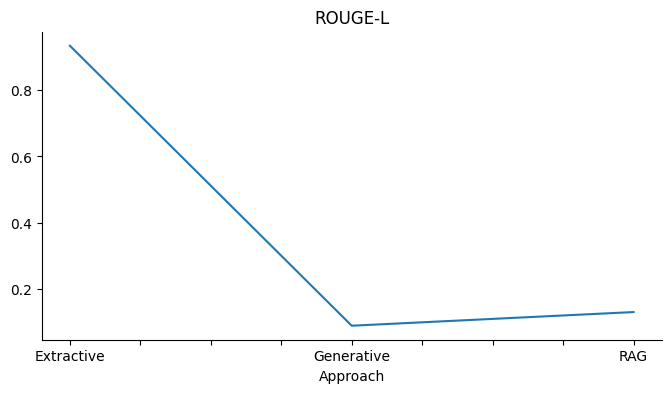

In [14]:
# @title ROUGE-L

from matplotlib import pyplot as plt
df['ROUGE-L'].plot(kind='line', figsize=(8, 4), title='ROUGE-L')
plt.gca().spines[['top', 'right']].set_visible(False)